## Step 1: Load and Split Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load cleaned data
df = pd.read_csv("../data/processed/cleaned_bank_churn.csv")

# Separate features and target
X = df.drop("Exited", axis=1)
y = df["Exited"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (8000, 11)
Test shape: (2000, 11)


## Step 2: Train XGBoost Classifier

In [2]:
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


### Step 3: Evaluate Model Performance

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1593
           1       0.71      0.47      0.57       407

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000



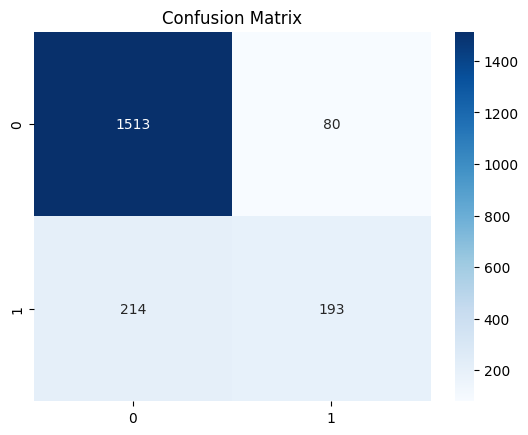

ROC AUC Score: 0.8278


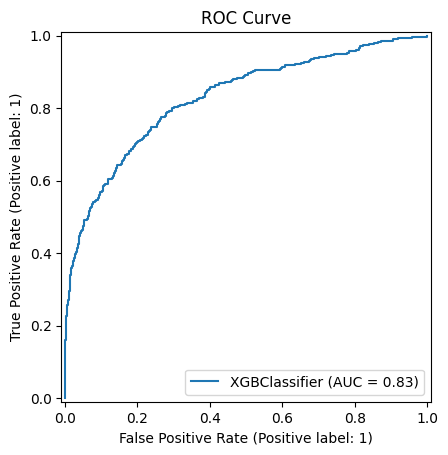

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


### Step 4: Feature Importance

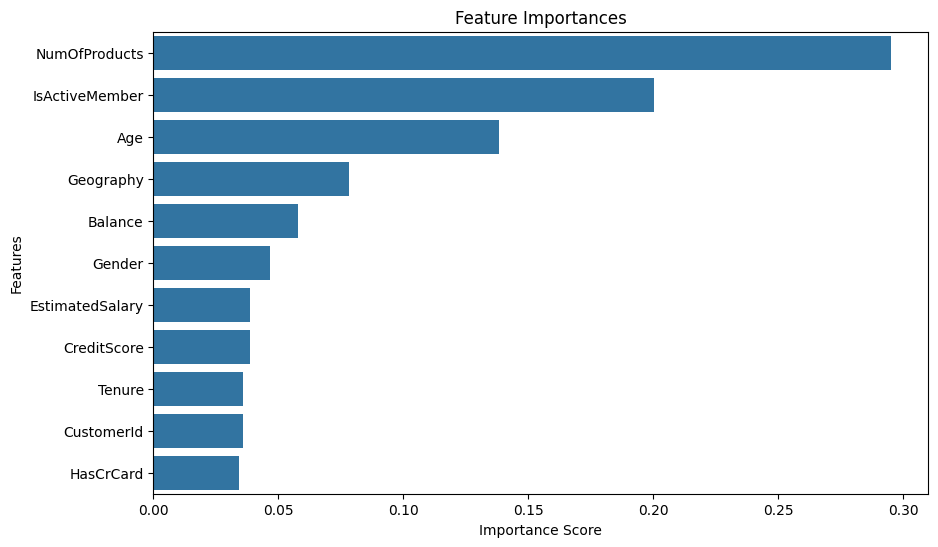

In [4]:
import numpy as np

# Plot top features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Feature names sorted
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


### Add Churn Risk Score to Dataset

In [5]:
# Add churn probability to test set
X_test_copy = X_test.copy()
X_test_copy['Churn_Probability'] = y_proba
X_test_copy['Actual_Churn'] = y_test.values

# Add ID info back from original dataset
original = pd.read_csv("../data/raw/BankChurners.csv")
X_test_copy['CustomerId'] = original.loc[X_test_copy.index, 'CustomerId'].values
X_test_copy['Geography'] = original.loc[X_test_copy.index, 'Geography'].values
X_test_copy['Age'] = original.loc[X_test_copy.index, 'Age'].values
X_test_copy['Balance'] = original.loc[X_test_copy.index, 'Balance'].values

# Save to CSV for dashboard use
X_test_copy.to_csv("../data/processed/churn_scored_customers.csv", index=False)
